Using device: cuda
Processing new data from index 0 to 49999999
加载数据...
数据形状: (50000000, 4)
聚合访问计数...
设备 1 的热键数量: 100000
设备 2 的热键数量: 100000
设备 3 的热键数量: 100000
设备 4 的热键数量: 100000
设备 5 的热键数量: 100000
设备 6 的热键数量: 100000
设备 7 的热键数量: 100000
设备 8 的热键数量: 100000
设备 9 的热键数量: 100000
设备 10 的热键数量: 100000
设备 11 的热键数量: 100000
设备 12 的热键数量: 100000
设备 13 的热键数量: 100000
设备 14 的热键数量: 100000
设备 15 的热键数量: 100000
设备 16 的热键数量: 100000
设备 17 的热键数量: 100000
设备 18 的热键数量: 100000
设备 19 的热键数量: 100000
设备 20 的热键数量: 100000
训练样本数: 3952
测试样本数: 989
模型参数总数: 211,476
开始训练...
Epoch: 1/20 Loss: 3.007564
Epoch [1/20], Train Loss: 1.4639, Train Acc: 74.62%, Test Loss: 0.3289, Test Acc: 90.60%, LR: 0.001000
Epoch: 2/20 Loss: 0.460905
Epoch [2/20], Train Loss: 0.2647, Train Acc: 91.37%, Test Loss: 0.2202, Test Acc: 90.50%, LR: 0.001000
Epoch: 3/20 Loss: 0.304075
Epoch [3/20], Train Loss: 0.2186, Train Acc: 92.51%, Test Loss: 0.1792, Test Acc: 93.63%, LR: 0.001000
Epoch: 4/20 Loss: 0.159670
Epoch [4/20], Train Loss: 0.1674, Train Acc

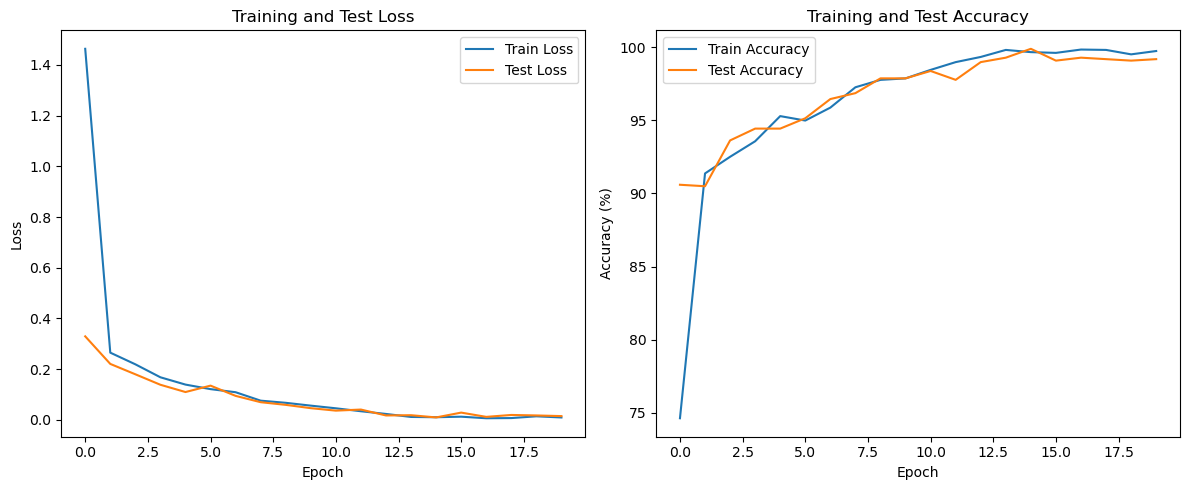

模型已保存到: lstm_predictor.pth
Error processing new data: 'DeviceAccessPredictor' object has no attribute 'get_recent_sequence'


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset
import pandas as pd 
import numpy as np
import socket
import threading
import time
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import select
import os
import re
import warnings
import json
from typing import List, Tuple, Dict, Any, Optional
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.2):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM层
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # 全连接层
        self.fc = nn.Linear(hidden_size, num_classes)
        
        # Dropout层
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # 初始化隐藏状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        
        return out

class DeviceAccessPredictor:
    """Main class for device access prediction with communication capabilities"""
    
    def __init__(self, sequence_length=60, num_devices=20, top_k_hot_keys=100000,batch_size = 64,
                 hidden_size = 128,num_layers = 2,num_epochs = 20,learning_rate = 0.001):
        self.sequence_length = sequence_length
        self.num_devices = num_devices
        self.top_k_hot_keys = top_k_hot_keys
        self.model = None,
        self.batch_size = batch_size
        self.scaler = StandardScaler()
        self.device_hot_keys = {}
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.input_size = num_devices
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.num_classes = num_devices
 
        
        print(f"Using device: {self.device}")
        
        # For data statistics
        self.stats = {}
        
        # Communication setup
        self.sock = None
        self.conn = None
        self.addr = None
        self.running = False
        
        # Log file path
        self.log_file = "/home/ming/桌面/PLIN-N /PLIN-N/data/workload_log.csv"
        
    def setup_communication(self, host='127.0.0.1', port=60001):
        """Set up socket communication with C++"""
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.sock.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        self.sock.bind((host, port))
        self.sock.listen(1)
        print(f"Listening for C++ connection on {host}:{port}")
        
        self.conn, self.addr = self.sock.accept()
        print(f"Connected to C++ at {self.addr}")
        
    def listen_for_messages(self):
        """Listen for messages from C++"""
        self.running = True
        
        while self.running:
            try:
                # Check if data is available
                ready = select.select([self.conn], [], [], 0.1)
                if ready[0]:
                    data = self.conn.recv(1024).decode('utf-8')
                    
                    if not data:
                        continue
                        
                    if data.startswith("INDEX:"):
                        # Parse index range
                        parts = data.split(":")
                        if len(parts) >= 3:
                            start_idx = int(parts[1])
                            end_idx = int(parts[2])
                            
                            # Process new data
                            self.train_and_predict(start_idx, end_idx)
                        
            except Exception as e:
                print(f"Error in communication: {e}")
                time.sleep(1)

    def analyze_hot_keys(self,df):

        device_hot_keys = {}
            
        # 获取所有设备ID
        device_ids = df["device_id"].unique()
        
        for device_id in device_ids:
            device_logs = df[df["device_id"] == device_id]
            key_counts = Counter(device_logs["key"])
                
            # 获取前top_k个最常访问的键
            hot_keys = [int(key) for key, count in key_counts.most_common(self.top_k_hot_keys)]
            device_hot_keys[int(device_id)] = hot_keys
            
        return device_hot_keys


    def save_hot_keys(self,device_hot_keys, filename="hot_keys.json"):
        """保存热键信息到JSON文件"""
        serializable_hot_keys = {}
        for device_id, keys in device_hot_keys.items():
            serializable_hot_keys[str(device_id)] = [str(key) for key in keys]
            
        with open(filename, 'w') as f:
            json.dump(serializable_hot_keys, f, indent=4)
        print(f"热键信息已保存到: {filename}")
        return filename
                
    
    def load_and_preprocess_data(self,start_idx,end_idx):
        """
        加载和预处理访问日志数据
        """
        print("加载数据...")
        nrows = end_idx - start_idx + 1
        header = pd.read_csv(self.log_file, nrows=0).columns
        df = pd.read_csv(self.log_file,
                 skiprows=start_idx + 1,   # 跳过表头+前面多余行
                 nrows=nrows,
                 names=header)  
        # df = pd.read_csv(self.log_file)
        print(f"数据形状: {df.shape}")
        
        # 确保时间戳是整数
        df['timestamp'] = df['timestamp'].astype(int)
        
        # 聚合每秒的访问计数
        print("聚合访问计数...")
        agg_df = df.groupby(['timestamp', 'device_id']).size().unstack(fill_value=0)
        
        # 确保所有时间戳都有记录
        max_time = df['timestamp'].max()
        agg_df = agg_df.reindex(range(int(max_time) + 1), fill_value=0)
        
        # 确保所有设备都有列
        for device_id in range(1, self.num_devices + 1):
            if device_id not in agg_df.columns:
                agg_df[device_id] = 0
        
        # 按设备ID排序列
        agg_df = agg_df[sorted(agg_df.columns)]
        agg_df.columns = [f'count_dev{i}' for i in range(1, self.num_devices + 1)]
        
        return agg_df, df
    
    def create_sequences(self,data, seq_length):
        """
        创建用于LSTM训练的序列数据
        """
        xs, ys = [], []
        
        for i in range(len(data) - seq_length):
            x = data[i:i+seq_length]
            y = data[i+seq_length]
            xs.append(x)
            ys.append(y)
            
        return np.array(xs), np.array(ys)
        
    def train_and_predict(self, start_idx, end_idx):
        """Process new data from the log file"""
        print(f"Processing new data from index {start_idx} to {end_idx}")
        agg_df, original_df = self.load_and_preprocess_data(start_idx,end_idx)
        hot_keys = self.analyze_hot_keys(original_df)
        # hot_keys_file = self.save_hot_keys(hot_keys, "hot_keys.json")
        for device_id, keys in hot_keys.items():
            print(f"设备 {device_id} 的热键数量: {len(keys)}")

        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(agg_df.values)

        try:
            X, y = self.create_sequences(scaled_data, self.sequence_length)
            y_labels = np.argmax(agg_df.values[self.sequence_length:], axis=1)
            
            X_tensor = torch.FloatTensor(X)
            y_tensor = torch.LongTensor(y_labels)
            
            dataset = TensorDataset(X_tensor, y_tensor)
            
            train_size = int(0.8 * len(dataset))
            test_size = len(dataset) - train_size
            train_dataset, test_dataset = torch.utils.data.random_split(
                dataset, [train_size, test_size], 
                generator=torch.Generator().manual_seed(42)
            )
            
            train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4, pin_memory=True)
            test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4, pin_memory=True)
            
            print(f"训练样本数: {len(train_dataset)}")
            print(f"测试样本数: {len(test_dataset)}")
            
            model = LSTMPredictor(self.input_size, self.hidden_size, self.num_layers, self.num_classes).to(self.device)
            total_params = sum(p.numel() for p in model.parameters())
            print(f"模型参数总数: {total_params:,}")
    
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate, weight_decay=1e-5)
    
            train_losses, test_losses, train_accuracies, test_accuracies = self.train_model(
             model, train_loader, test_loader, criterion, optimizer, self.num_epochs
            )

            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            plt.plot(train_losses, label='Train Loss')
            plt.plot(test_losses, label='Test Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.title('Training and Test Loss')
            
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracies, label='Train Accuracy')
            plt.plot(test_accuracies, label='Test Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy (%)')
            plt.legend()
            plt.title('Training and Test Accuracy')
            
            plt.tight_layout()
            plt.savefig('training_curves.png')
            plt.show()
            
            model_path = 'lstm_predictor.pth'
            torch.save({
                'model_state_dict': model.state_dict(),
                'scaler': scaler,
                'input_size': self.input_size,
                'hidden_size': self.hidden_size,
                'num_layers': self.num_layers,
                'num_classes': self.num_classes,
                'sequence_length': self.sequence_length
            }, model_path)
            
            print(f"模型已保存到: {model_path}")
    
            recent_sequence = self.get_recent_sequence()
            print(f"Recent sequence available for prediction: {len(recent_sequence)}")
            
            if len(recent_sequence) >= self.sequence_length:
                predicted_device = self.predict_next_device(recent_sequence)
                hot_keys = self.device_hot_keys.get(predicted_device, [])
                hot_keys_str = ",".join(map(str, hot_keys[:10000]))  # 只发送前100个热键
                
                # message = f"DEVICE:{predicted_device}:HOT_KEYS:{hot_keys_str}END"
                message = f"HOT_KEYS:{hot_keys_str}END"
                try:
                    self.conn.send(message.encode('utf-8'))
                    print(f"Sent prediction for device {predicted_device}")
                except Exception as e:
                    print(f"Error sending prediction: {e}")
       
        except Exception as e:
            print(f"Error processing new data: {e}")


    
    # 训练函数
    def train_model(self,model, train_loader, test_loader, criterion, optimizer, num_epochs):
        """
        训练模型
        """
        train_losses = []
        test_losses = []
        train_accuracies = []
        test_accuracies = []
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5, verbose=True
        )
        
        print("开始训练...")
        start_time = time.time()
        
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(self.device), target.to(self.device)
                output = model(data)
                loss = criterion(output, target)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
                
                if batch_idx % 100 == 0:
                    print(f'Epoch: {epoch+1}/{num_epochs} '
                        f'Loss: {loss.item():.6f}')
            
            train_accuracy = 100. * train_correct / train_total
            avg_train_loss = train_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            train_accuracies.append(train_accuracy)
        
            model.eval()
            test_loss = 0.0
            test_correct = 0
            test_total = 0
            
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(self.device), target.to(self.device)
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    _, predicted = torch.max(output.data, 1)
                    test_total += target.size(0)
                    test_correct += (predicted == target).sum().item()
            
            test_accuracy = 100. * test_correct / test_total
            avg_test_loss = test_loss / len(test_loader)
            test_losses.append(avg_test_loss)
            test_accuracies.append(test_accuracy)
            
        
            scheduler.step(avg_test_loss)
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
                f'Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%, '
                f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        end_time = time.time()
        print(f'训练完成! 总耗时: {(end_time - start_time):.2f} s')
        
        return train_losses, test_losses, train_accuracies, test_accuracies
        
    
    def save_model(self, filepath: str):
        """Save the trained model and metadata"""
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'scaler': self.scaler,
            'input_size': self.num_devices,
            'hidden_size': 128,
            'num_layers': 2,
            'num_classes': self.num_devices,
            'sequence_length': self.sequence_length,
            'device_hot_keys': self.device_hot_keys
        }
        torch.save(checkpoint, filepath)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath: str):
        """Load a trained model and metadata"""
        checkpoint = torch.load(filepath, map_location=self.device)
        
        input_size = checkpoint['input_size']
        hidden_size = checkpoint['hidden_size']
        num_layers = checkpoint['num_layers']
        num_classes = checkpoint['num_classes']
        
        self.model = LSTMPredictor(input_size, hidden_size, num_layers, num_classes).to(self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.scaler = checkpoint['scaler']
        self.device_hot_keys = checkpoint.get('device_hot_keys', {})
        
        print(f"Model loaded from {filepath}")
    
    def stop(self):
        """Stop the communication thread"""
        self.running = False
        if self.conn:
            self.conn.close()
        if self.sock:
            self.sock.close()

def main():
    # Create predictor instance
    predictor = DeviceAccessPredictor(
        sequence_length=60,
        num_devices=20,
        top_k_hot_keys=100000
    )
    
    # only for test                12000000
    predictor.train_and_predict(0, 49999999)
if __name__ == "__main__":
    main()

### 下面是真实用于数据库预测的retrain和fine_turning版本

Using device: cuda
Processing new data from index 0 to 12000000
加载数据...
数据形状: (12000001, 4)
聚合访问计数...
设备 1 的热键数量: 49872
设备 2 的热键数量: 49660
设备 3 的热键数量: 50085
设备 4 的热键数量: 49791
设备 5 的热键数量: 49930
设备 6 的热键数量: 50064
设备 7 的热键数量: 50127
设备 8 的热键数量: 50002
设备 9 的热键数量: 50055
设备 10 的热键数量: 50089
设备 11 的热键数量: 50161
设备 12 的热键数量: 50108
设备 13 的热键数量: 50116
设备 14 的热键数量: 49841
设备 15 的热键数量: 50094
设备 16 的热键数量: 50013
设备 17 的热键数量: 49943
设备 18 的热键数量: 50408
设备 19 的热键数量: 49815
设备 20 的热键数量: 50039
训练样本数: 912
测试样本数: 229
模型参数总数: 211,476
开始训练...
Epoch: 1/20 Loss: 2.986146
Epoch [1/20], Train Loss: 2.8562, Train Acc: 37.39%, Test Loss: 2.5662, Test Acc: 82.10%, LR: 0.001000
Epoch: 2/20 Loss: 2.570307
Epoch [2/20], Train Loss: 1.9295, Train Acc: 77.63%, Test Loss: 1.2370, Test Acc: 80.79%, LR: 0.001000
Epoch: 3/20 Loss: 1.156536
Epoch [3/20], Train Loss: 0.8653, Train Acc: 82.02%, Test Loss: 0.6099, Test Acc: 84.28%, LR: 0.001000
Epoch: 4/20 Loss: 0.592902
Epoch [4/20], Train Loss: 0.5195, Train Acc: 87.17%, Test Loss: 

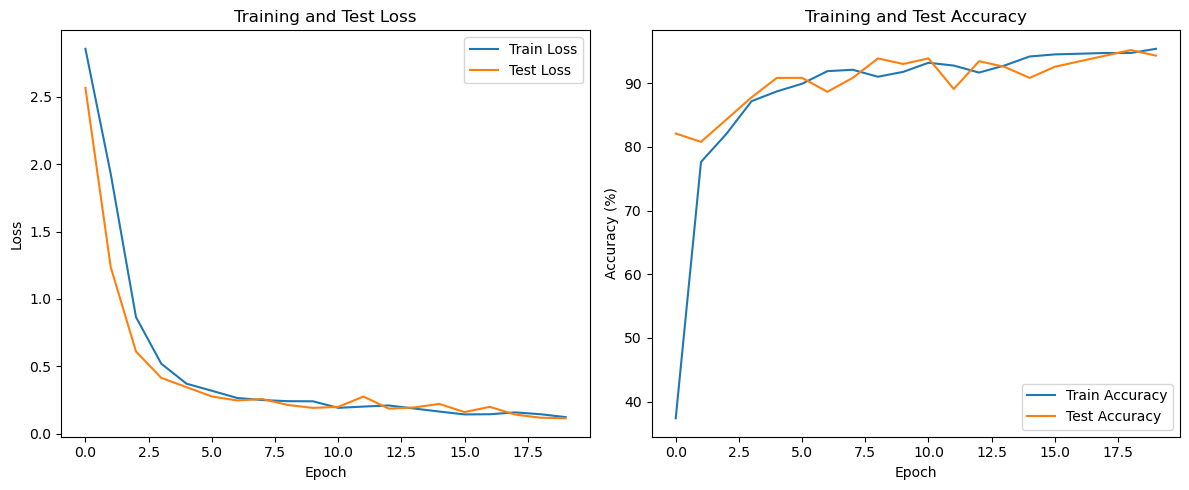

训练曲线已保存到: training_curves.png
Model saved to lstm_predictor.pth
Recent sequence available for prediction: 60
target_device1


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd 
import numpy as np
import socket
import threading
import time
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import select
import os
import re
import warnings
import json
from typing import List, Tuple, Dict, Any, Optional
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.2):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM层
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # 全连接层
        self.fc = nn.Linear(hidden_size, num_classes)
        
        # Dropout层
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # 初始化隐藏状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        
        return out

class DeviceAccessPredictor:
    """Main class for device access prediction with communication capabilities"""
    
    def __init__(self, sequence_length=60, num_devices=20, top_k_hot_keys=100000, batch_size=64,
                 hidden_size=128, num_layers=2, num_epochs=20, learning_rate=0.001,retrain_record = 2400000):
        self.sequence_length = sequence_length
        self.num_devices = num_devices
        self.top_k_hot_keys = top_k_hot_keys
        self.model = None
        self.batch_size = batch_size
        self.scaler = StandardScaler()
        self.device_hot_keys = {}
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.input_size = num_devices
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.num_classes = num_devices
        self.retrain_record =  retrain_record
        
        self.model_path = 'lstm_predictor.pth'
 
        print(f"Using device: {self.device}")
        
        # For data statistics
        self.stats = {}
        
        # Communication setup
        self.sock = None
        self.conn = None
        self.addr = None
        self.running = False
        
        # Log file path
        self.log_file = "/home/ming/桌面/PLIN-N /PLIN-N/data/workload_log.csv"
        
    def setup_communication(self, host='127.0.0.1', port=60001):
        """Set up socket communication with C++"""
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.sock.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        self.sock.bind((host, port))
        self.sock.listen(1)
        print(f"Listening for C++ connection on {host}:{port}")
        
        self.conn, self.addr = self.sock.accept()
        print(f"Connected to C++ at {self.addr}")
        
    def listen_for_messages(self):
        """Listen for messages from C++"""
        self.running = True
        
        while self.running:
            try:
                # Check if data is available
                ready = select.select([self.conn], [], [], 0.1)
                if ready[0]:
                    data = self.conn.recv(1024).decode('utf-8')
                    
                    if not data:
                        continue
                        
                    if data.startswith("INDEX:"):
                        parts = data.split(":")
                        if len(parts) >= 3:
                            start_idx = int(parts[1])
                            end_idx = int(parts[2])
                            self.train_and_predict(start_idx, end_idx)

                    if data.startswith('ADJUST0'):
                        parts = data.split(":")
                        end_pos = int(parts[1])
                        self.simply_predict(end_idx = end_pos)

                        
            except Exception as e:
                print(f"Error in communication: {e}")
                time.sleep(1)

    def analyze_hot_keys(self, df):
        device_hot_keys = {}
            
        # 获取所有设备ID
        device_ids = df["device_id"].unique()
        
        for device_id in device_ids:
            device_logs = df[df["device_id"] == device_id]
            key_counts = Counter(device_logs["key"])
                
            # 获取前top_k个最常访问的键
            hot_keys = [int(key) for key, count in key_counts.most_common(self.top_k_hot_keys)]
            device_hot_keys[int(device_id)] = hot_keys
            
        return device_hot_keys

    def save_hot_keys(self, device_hot_keys, filename="hot_keys.json"):
        """保存热键信息到JSON文件"""
        serializable_hot_keys = {}
        for device_id, keys in device_hot_keys.items():
            serializable_hot_keys[str(device_id)] = [str(key) for key in keys]
            
        with open(filename, 'w') as f:
            json.dump(serializable_hot_keys, f, indent=4)
        print(f"热键信息已保存到: {filename}")
        return filename
                
    
    def load_and_preprocess_data(self, start_idx, end_idx):
        """
        加载和预处理访问日志数据
        """
        print("加载数据...")
        nrows = end_idx - start_idx + 1
        header = pd.read_csv(self.log_file, nrows=0).columns
        df = pd.read_csv(self.log_file,
                 skiprows=start_idx + 1,   # 跳过表头+前面多余行
                 nrows=nrows,
                 names=header)  
        print(f"数据形状: {df.shape}")
        
        df['timestamp'] = df['timestamp'].astype(int)
        
        print("聚合访问计数...")
        agg_df = df.groupby(['timestamp', 'device_id']).size().unstack(fill_value=0)
        
        max_time = df['timestamp'].max()
        agg_df = agg_df.reindex(range(int(max_time) + 1), fill_value=0)
        
        for device_id in range(1, self.num_devices + 1):
            if device_id not in agg_df.columns:
                agg_df[device_id] = 0
        
        agg_df = agg_df[sorted(agg_df.columns)]
        agg_df.columns = [f'count_dev{i}' for i in range(1, self.num_devices + 1)]
        
        return agg_df, df
    
    def create_sequences(self, data, seq_length):
        xs, ys = [], []
        
        for i in range(len(data) - seq_length):
            x = data[i:i+seq_length]
            y = data[i+seq_length]
            xs.append(x)
            ys.append(y)
            
        return np.array(xs), np.array(ys)
    
    def get_recent_sequence(self,log_end_index):
        try:
            begin_index = log_end_index - self.retrain_record 
            if begin_index != 0 :
                begin_index = 0
    
            df = pd.read_csv(self.log_file,
                             skiprows = begin_index )
            df = pd.read_csv(self.log_file)
            df['timestamp'] = df['timestamp'].astype(int)
            
            agg_df = df.groupby(['timestamp', 'device_id']).size().unstack(fill_value=0)
            
            max_time = df['timestamp'].max()
            agg_df = agg_df.reindex(range(int(max_time) + 1), fill_value=0)
            
            for device_id in range(1, self.num_devices + 1):
                if device_id not in agg_df.columns:
                    agg_df[device_id] = 0
            
           
            agg_df = agg_df[sorted(agg_df.columns)]
            agg_df.columns = [f'count_dev{i}' for i in range(1, self.num_devices + 1)]
            
            scaled_data = self.scaler.transform(agg_df.values)
            
            if len(scaled_data) >= self.sequence_length:
                recent_sequence = scaled_data[-self.sequence_length:]
            else:
                # 如果数据不够，可以用0填充
                padding = np.zeros((self.sequence_length - len(scaled_data), self.num_devices))
                recent_sequence = np.vstack((padding, scaled_data))
            
            return recent_sequence
        except Exception as e:
            print(f"Error getting recent sequence: {e}")
            return None
    
    def predict_next_device(self, recent_sequence):
        """预测下一个设备"""
        if recent_sequence is None or len(recent_sequence) < self.sequence_length:
            print(f"Not enough data for prediction. Need {self.sequence_length} sequences, got {len(recent_sequence) if recent_sequence is not None else 0}")
            return None
        
        # 将recent_sequence转换为模型输入的格式
        # recent_sequence的形状为(sequence_length, num_devices)
        # 需要增加一个批次维度
        input_tensor = torch.FloatTensor(recent_sequence).unsqueeze(0).to(self.device)
        
        self.model.eval()
        with torch.no_grad():
            output = self.model(input_tensor)
            predicted_class = torch.argmax(output, dim=1).item()
        
        # 预测的类别是0-indexed，设备ID是1-indexed，所以需要加1
        predicted_device = predicted_class + 1
        
        return predicted_device
        
    def train_and_predict(self, start_idx, end_idx):
        """Process new data from the log file"""
        print(f"Processing new data from index {start_idx} to {end_idx}")
        agg_df, original_df = self.load_and_preprocess_data(start_idx, end_idx)
        hot_keys = self.analyze_hot_keys(original_df)
        self.device_hot_keys = hot_keys  
        
        for device_id, keys in hot_keys.items():
            print(f"设备 {device_id} 的热键数量: {len(keys)}")

        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(agg_df.values)
        self.scaler = scaler  # 保存标准化器到实例变量

        try:
            X, y = self.create_sequences(scaled_data, self.sequence_length)
            y_labels = np.argmax(agg_df.values[self.sequence_length:], axis=1)
            
            X_tensor = torch.FloatTensor(X)
            y_tensor = torch.LongTensor(y_labels)
            
            dataset = TensorDataset(X_tensor, y_tensor)
            
            train_size = int(0.8 * len(dataset))
            test_size = len(dataset) - train_size
            train_dataset, test_dataset = torch.utils.data.random_split(
                dataset, [train_size, test_size], 
                generator=torch.Generator().manual_seed(42)
            )
            
            train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4, pin_memory=True)
            test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4, pin_memory=True)
            
            print(f"训练样本数: {len(train_dataset)}")
            print(f"测试样本数: {len(test_dataset)}")
            
            model = LSTMPredictor(self.input_size, self.hidden_size, self.num_layers, self.num_classes).to(self.device)
            self.model = model  # 保存模型到实例变量
            
            total_params = sum(p.numel() for p in model.parameters())
            print(f"模型参数总数: {total_params:,}")
    
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate, weight_decay=1e-5)
    
            train_losses, test_losses, train_accuracies, test_accuracies = self.train_model(
                model, train_loader, test_loader, criterion, optimizer, self.num_epochs
            )

            self.visualize_training_curves(train_losses, test_losses, train_accuracies, test_accuracies)
            self.save_model(self.model_path)
    
            recent_sequence = self.get_recent_sequence(end_idx)
            print(f"Recent sequence available for prediction: {len(recent_sequence) if recent_sequence is not None else 0}")
            
            if recent_sequence is not None and len(recent_sequence) >= self.sequence_length:
                predicted_device = self.predict_next_device(recent_sequence)
                if predicted_device is not None:
                    hot_keys = self.device_hot_keys.get(predicted_device, [])
                    print(f"target_device{predicted_device}")
                    # hot_keys_str = ",".join(map(str, hot_keys[:self.top_k_hot_keys]))  
                    
                    # message = f"HOT_KEYS:{hot_keys_str}END"
                    # try:
                    #     self.conn.send(message.encode('utf-8'))
                    #     print(f"Sent prediction for device {predicted_device}")
                    # except Exception as e:
                    #     print(f"Error sending prediction: {e}")
                else:
                    print("Failed to predict next device")
            else:
                print("Not enough data for prediction")
       
        except Exception as e:
            print(f"Error processing new data: {e}")

    def train_model(self, model, train_loader, test_loader, criterion, optimizer, num_epochs):
        """
        训练模型
        """
        train_losses = []
        test_losses = []
        train_accuracies = []
        test_accuracies = []
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5, verbose=True
        )
        
        print("开始训练...")
        start_time = time.time()
        
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(self.device), target.to(self.device)
                output = model(data)
                loss = criterion(output, target)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
                
                if batch_idx % 100 == 0:
                    print(f'Epoch: {epoch+1}/{num_epochs} '
                        f'Loss: {loss.item():.6f}')
            
            train_accuracy = 100. * train_correct / train_total
            avg_train_loss = train_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            train_accuracies.append(train_accuracy)
        
            model.eval()
            test_loss = 0.0
            test_correct = 0
            test_total = 0
            
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(self.device), target.to(self.device)
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    _, predicted = torch.max(output.data, 1)
                    test_total += target.size(0)
                    test_correct += (predicted == target).sum().item()
            
            test_accuracy = 100. * test_correct / test_total
            avg_test_loss = test_loss / len(test_loader)
            test_losses.append(avg_test_loss)
            test_accuracies.append(test_accuracy)
            
        
            scheduler.step(avg_test_loss)
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
                f'Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%, '
                f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        end_time = time.time()
        print(f'训练完成! 总耗时: {(end_time - start_time):.2f} s')
        
        return train_losses, test_losses, train_accuracies, test_accuracies
    
    def simply_predict(self,end_idx):
        recent_sequence = self.get_recent_sequence(end_idx)
        print(f"Recent sequence available for prediction: {len(recent_sequence) if recent_sequence is not None else 0}")
            
        if recent_sequence is not None and len(recent_sequence) >= self.sequence_length:
            predicted_device = self.predict_next_device(recent_sequence)
            if predicted_device is not None:
                hot_keys = self.device_hot_keys.get(predicted_device, [])
                hot_keys_str = ",".join(map(str, hot_keys[:self.top_k_hot_keys]))  
                    
                message = f"HOT_KEYS:{hot_keys_str}END"
                try:
                    self.conn.send(message.encode('utf-8'))
                    print(f"Sent prediction for device {predicted_device}")
                except Exception as e:
                    print(f"Error sending prediction: {e}")
            else:
                print("Failed to predict next device")
        else:
            print("Not enough data for prediction")

    
    def visualize_training_curves(self,train_losses, test_losses, train_accuracies, test_accuracies, save_path='training_curves.png'):
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Test Loss')
        
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Train Accuracy')
        plt.plot(test_accuracies, label='Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.title('Training and Test Accuracy')
        
        plt.tight_layout()
        plt.savefig(save_path)
        plt.show()
        print(f"训练曲线已保存到: {save_path}")
        
    def save_model(self, filepath: str):
        """Save the trained model and metadata"""
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'scaler': self.scaler,
            'input_size': self.num_devices,
            'hidden_size': 128,
            'num_layers': 2,
            'num_classes': self.num_devices,
            'sequence_length': self.sequence_length,
            'device_hot_keys': self.device_hot_keys
        }
        torch.save(checkpoint, filepath)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath: str):
        """Load a trained model and metadata"""
        checkpoint = torch.load(filepath, map_location=self.device)
        
        input_size = checkpoint['input_size']
        hidden_size = checkpoint['hidden_size']
        num_layers = checkpoint['num_layers']
        num_classes = checkpoint['num_classes']
        
        self.model = LSTMPredictor(input_size, hidden_size, num_layers, num_classes).to(self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.scaler = checkpoint['scaler']
        self.device_hot_keys = checkpoint.get('device_hot_keys', {})
        
        print(f"Model loaded from {filepath}")
    
    def stop(self):
        """Stop the communication thread"""
        self.running = False
        if self.conn:
            self.conn.close()
        if self.sock:
            self.sock.close()

def main():
    predictor = DeviceAccessPredictor(
        sequence_length=60,
        num_devices=20,
        top_k_hot_keys=100000, # 每个设备的热键数量 
        retrain_record= (60 + 10)*300000
    )
    
    # if os.path.exists('best_device_model.pth'):
    #     print("Loading pre-trained model...")
    #     predictor.load_model('best_device_model.pth')
    predictor.train_and_predict(0,12000000)
    # print("Setting up communication with C++...")
    # predictor.setup_communication("127.0.0.1", 60001)  
    
    # comm_thread = threading.Thread(target=predictor.listen_for_messages)
    # comm_thread.daemon = True
    # comm_thread.start()
    
    # try:
    #     print("Python device predictor is running. Press Ctrl+C to stop.")
    #     while True:
    #         time.sleep(1)
    # except KeyboardInterrupt:
    #     print("Stopping predictor...")
    #     predictor.stop()

if __name__ == "__main__":
    main()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd 
import numpy as np
import socket
import threading
import time
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import select
import os
import re
import warnings
import json
from typing import List, Tuple, Dict, Any, Optional
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.2):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM层
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # 全连接层
        self.fc = nn.Linear(hidden_size, num_classes)
        
        # Dropout层
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # 初始化隐藏状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        
        return out

class DeviceAccessPredictor:
    """Main class for device access prediction with communication capabilities"""
    
    def __init__(self, sequence_length=60, num_devices=20, top_k_hot_keys=100000, batch_size=64,
                 hidden_size=128, num_layers=2, num_epochs=20, learning_rate=0.001,retrain_record = 2400000):
        self.sequence_length = sequence_length
        self.num_devices = num_devices
        self.top_k_hot_keys = top_k_hot_keys
        self.model = None
        self.batch_size = batch_size
        self.scaler = StandardScaler()
        self.device_hot_keys = {}
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.input_size = num_devices
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.num_classes = num_devices
        self.retrain_record =  retrain_record
        
        self.model_path = 'lstm_predictor.pth'
 
        print(f"Using device: {self.device}")
        
        # For data statistics
        self.stats = {}
        
        # Communication setup
        self.sock = None
        self.conn = None
        self.addr = None
        self.running = False
        
        # Log file path
        self.log_file = "/home/ming/桌面/PLIN-N /PLIN-N/data/workload_log.csv"
        
    def setup_communication(self, host='127.0.0.1', port=60001):
        """Set up socket communication with C++"""
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.sock.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        self.sock.bind((host, port))
        self.sock.listen(1)
        print(f"Listening for C++ connection on {host}:{port}")
        
        self.conn, self.addr = self.sock.accept()
        print(f"Connected to C++ at {self.addr}")
        
    def listen_for_messages(self):
        """Listen for messages from C++"""
        self.running = True
        
        while self.running:
            try:
                # Check if data is available
                ready = select.select([self.conn], [], [], 0.1)
                if ready[0]:
                    data = self.conn.recv(1024).decode('utf-8')
                    
                    if not data:
                        continue
                        
                    if data.startswith("INDEX:"):
                        parts = data.split(":")
                        if len(parts) >= 3:
                            start_idx = int(parts[1])
                            end_idx = int(parts[2])
                            self.train_and_predict(start_idx, end_idx)

                    if data.startswith('ADJUST0'):
                        parts = data.split(":")
                        end_pos = int(parts[1])
                        self.simply_predict(end_idx = end_pos)

                        
            except Exception as e:
                print(f"Error in communication: {e}")
                time.sleep(1)

    def analyze_hot_keys(self, df):
        device_hot_keys = {}
            
        # 获取所有设备ID
        device_ids = df["device_id"].unique()
        
        for device_id in device_ids:
            device_logs = df[df["device_id"] == device_id]
            key_counts = Counter(device_logs["key"])
                
            # 获取前top_k个最常访问的键
            hot_keys = [int(key) for key, count in key_counts.most_common(self.top_k_hot_keys)]
            device_hot_keys[int(device_id)] = hot_keys
            
        return device_hot_keys

    def save_hot_keys(self, device_hot_keys, filename="hot_keys.json"):
        """保存热键信息到JSON文件"""
        serializable_hot_keys = {}
        for device_id, keys in device_hot_keys.items():
            serializable_hot_keys[str(device_id)] = [str(key) for key in keys]
            
        with open(filename, 'w') as f:
            json.dump(serializable_hot_keys, f, indent=4)
        print(f"热键信息已保存到: {filename}")
        return filename
                
    
    def load_and_preprocess_data(self, start_idx, end_idx):
        """
        加载和预处理访问日志数据
        """
        print("加载数据...")
        nrows = end_idx - start_idx + 1
        header = pd.read_csv(self.log_file, nrows=0).columns
        df = pd.read_csv(self.log_file,
                 skiprows=start_idx + 1,   # 跳过表头+前面多余行
                 nrows=nrows,
                 names=header)  
        print(f"数据形状: {df.shape}")
        
        df['timestamp'] = df['timestamp'].astype(int)
        
        print("聚合访问计数...")
        agg_df = df.groupby(['timestamp', 'device_id']).size().unstack(fill_value=0)
        
        max_time = df['timestamp'].max()
        agg_df = agg_df.reindex(range(int(max_time) + 1), fill_value=0)
        
        for device_id in range(1, self.num_devices + 1):
            if device_id not in agg_df.columns:
                agg_df[device_id] = 0
        
        agg_df = agg_df[sorted(agg_df.columns)]
        agg_df.columns = [f'count_dev{i}' for i in range(1, self.num_devices + 1)]
        
        return agg_df, df
    
    def create_sequences(self, data, seq_length):
        xs, ys = [], []
        
        for i in range(len(data) - seq_length):
            x = data[i:i+seq_length]
            y = data[i+seq_length]
            xs.append(x)
            ys.append(y)
            
        return np.array(xs), np.array(ys)
    
    def get_recent_sequence(self,log_end_index):
        try:
            begin_index = log_end_index - self.retrain_record 
            if begin_index != 0 :
                begin_index = 0
    
            df = pd.read_csv(self.log_file,
                             skiprows = begin_index )
            # df = pd.read_csv(self.log_file)
            df['timestamp'] = df['timestamp'].astype(int)
            
            agg_df = df.groupby(['timestamp', 'device_id']).size().unstack(fill_value=0)
            
            max_time = df['timestamp'].max()
            agg_df = agg_df.reindex(range(int(max_time) + 1), fill_value=0)
            
            for device_id in range(1, self.num_devices + 1):
                if device_id not in agg_df.columns:
                    agg_df[device_id] = 0
            
           
            agg_df = agg_df[sorted(agg_df.columns)]
            agg_df.columns = [f'count_dev{i}' for i in range(1, self.num_devices + 1)]
            
            scaled_data = self.scaler.transform(agg_df.values)
            
            if len(scaled_data) >= self.sequence_length:
                recent_sequence = scaled_data[-self.sequence_length:]
            else:
                # 如果数据不够，可以用0填充
                padding = np.zeros((self.sequence_length - len(scaled_data), self.num_devices))
                recent_sequence = np.vstack((padding, scaled_data))
            
            return recent_sequence
        except Exception as e:
            print(f"Error getting recent sequence: {e}")
            return None
    
    def predict_next_device(self, recent_sequence):
        """预测下一个设备"""
        if recent_sequence is None or len(recent_sequence) < self.sequence_length:
            print(f"Not enough data for prediction. Need {self.sequence_length} sequences, got {len(recent_sequence) if recent_sequence is not None else 0}")
            return None
        
        # 将recent_sequence转换为模型输入的格式
        # recent_sequence的形状为(sequence_length, num_devices)
        # 需要增加一个批次维度
        input_tensor = torch.FloatTensor(recent_sequence).unsqueeze(0).to(self.device)
        
        self.model.eval()
        with torch.no_grad():
            output = self.model(input_tensor)
            predicted_class = torch.argmax(output, dim=1).item()
        
        # 预测的类别是0-indexed，设备ID是1-indexed，所以需要加1
        predicted_device = predicted_class + 1
        
        return predicted_device
        
    def train_and_predict(self, start_idx, end_idx):
        """Process new data from the log file"""
        print(f"Processing new data from index {start_idx} to {end_idx}")
        agg_df, original_df = self.load_and_preprocess_data(start_idx, end_idx)
        hot_keys = self.analyze_hot_keys(original_df)
        self.device_hot_keys = hot_keys  
        
        for device_id, keys in hot_keys.items():
            print(f"设备 {device_id} 的热键数量: {len(keys)}")

        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(agg_df.values)
        self.scaler = scaler  # 保存标准化器到实例变量

        try:
            X, y = self.create_sequences(scaled_data, self.sequence_length)
            y_labels = np.argmax(agg_df.values[self.sequence_length:], axis=1)
            
            X_tensor = torch.FloatTensor(X)
            y_tensor = torch.LongTensor(y_labels)
            
            dataset = TensorDataset(X_tensor, y_tensor)
            
            train_size = int(0.8 * len(dataset))
            test_size = len(dataset) - train_size
            train_dataset, test_dataset = torch.utils.data.random_split(
                dataset, [train_size, test_size], 
                generator=torch.Generator().manual_seed(42)
            )
            
            train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4, pin_memory=True)
            test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4, pin_memory=True)
            
            print(f"训练样本数: {len(train_dataset)}")
            print(f"测试样本数: {len(test_dataset)}")
            
            model = LSTMPredictor(self.input_size, self.hidden_size, self.num_layers, self.num_classes).to(self.device)
            self.model = model  # 保存模型到实例变量
            
            total_params = sum(p.numel() for p in model.parameters())
            print(f"模型参数总数: {total_params:,}")
    
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate, weight_decay=1e-5)
    
            train_losses, test_losses, train_accuracies, test_accuracies = self.train_model(
                model, train_loader, test_loader, criterion, optimizer, self.num_epochs
            )

            # self.visualize_training_curves(train_losses, test_losses, train_accuracies, test_accuracies)
            self.save_model(self.model_path)
    
            recent_sequence = self.get_recent_sequence(end_idx)
            print(f"Recent sequence available for prediction: {len(recent_sequence) if recent_sequence is not None else 0}")
            
            if recent_sequence is not None and len(recent_sequence) >= self.sequence_length:
                predicted_device = self.predict_next_device(recent_sequence)
                if predicted_device is not None:
                    hot_keys = self.device_hot_keys.get(predicted_device, [])
                    print(f"target_device{predicted_device}")
                    hot_keys_str = ",".join(map(str, hot_keys[:self.top_k_hot_keys]))  
                    message = f"HOT_KEYS:{hot_keys_str}END"
                    # try:
                    #     self.conn.send(message.encode('utf-8'))
                    #     print(f"Sent prediction for device {predicted_device}")
                    # except Exception as e:
                    #     print(f"Error sending prediction: {e}")
                else:
                    print("Failed to predict next device")
            else:
                print("Not enough data for prediction")
       
        except Exception as e:
            print(f"Error processing new data: {e}")

    def train_model(self, model, train_loader, test_loader, criterion, optimizer, num_epochs):
        """
        训练模型
        """
        train_losses = []
        test_losses = []
        train_accuracies = []
        test_accuracies = []
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5, verbose=True
        )
        
        print("开始训练...")
        start_time = time.time()
        
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(self.device), target.to(self.device)
                output = model(data)
                loss = criterion(output, target)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
                
                if batch_idx % 100 == 0:
                    print(f'Epoch: {epoch+1}/{num_epochs} '
                        f'Loss: {loss.item():.6f}')
            
            train_accuracy = 100. * train_correct / train_total
            avg_train_loss = train_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            train_accuracies.append(train_accuracy)
        
            model.eval()
            test_loss = 0.0
            test_correct = 0
            test_total = 0
            
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(self.device), target.to(self.device)
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    _, predicted = torch.max(output.data, 1)
                    test_total += target.size(0)
                    test_correct += (predicted == target).sum().item()
            
            test_accuracy = 100. * test_correct / test_total
            avg_test_loss = test_loss / len(test_loader)
            test_losses.append(avg_test_loss)
            test_accuracies.append(test_accuracy)
            
        
            scheduler.step(avg_test_loss)
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
                f'Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%, '
                f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        end_time = time.time()
        print(f'训练完成! 总耗时: {(end_time - start_time):.2f} s')
        
        return train_losses, test_losses, train_accuracies, test_accuracies
    
    def simply_predict(self,end_idx):
        recent_sequence = self.get_recent_sequence(end_idx)
        print(f"Recent sequence available for prediction: {len(recent_sequence) if recent_sequence is not None else 0}")
            
        if recent_sequence is not None and len(recent_sequence) >= self.sequence_length:
            predicted_device = self.predict_next_device(recent_sequence)
            if predicted_device is not None:
                hot_keys = self.device_hot_keys.get(predicted_device, [])
                hot_keys_str = ",".join(map(str, hot_keys[:self.top_k_hot_keys]))  
                    
                message = f"HOT_KEYS:{hot_keys_str}END"
                try:
                    self.conn.send(message.encode('utf-8'))
                    print(f"Sent prediction for device {predicted_device}")
                except Exception as e:
                    print(f"Error sending prediction: {e}")
            else:
                print("Failed to predict next device")
        else:
            print("Not enough data for prediction")

    
    def visualize_training_curves(self,train_losses, test_losses, train_accuracies, test_accuracies, save_path='training_curves.png'):
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Test Loss')
        
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Train Accuracy')
        plt.plot(test_accuracies, label='Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.title('Training and Test Accuracy')
        
        plt.tight_layout()
        plt.savefig(save_path)
        plt.show()
        print(f"训练曲线已保存到: {save_path}")
        
    def save_model(self, filepath: str):
        """Save the trained model and metadata"""
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'scaler': self.scaler,
            'input_size': self.num_devices,
            'hidden_size': 128,
            'num_layers': 2,
            'num_classes': self.num_devices,
            'sequence_length': self.sequence_length,
            'device_hot_keys': self.device_hot_keys
        }
        torch.save(checkpoint, filepath)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath: str):
        """Load a trained model and metadata"""
        checkpoint = torch.load(filepath, map_location=self.device)
        
        input_size = checkpoint['input_size']
        hidden_size = checkpoint['hidden_size']
        num_layers = checkpoint['num_layers']
        num_classes = checkpoint['num_classes']
        
        self.model = LSTMPredictor(input_size, hidden_size, num_layers, num_classes).to(self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.scaler = checkpoint['scaler']
        self.device_hot_keys = checkpoint.get('device_hot_keys', {})
        
        print(f"Model loaded from {filepath}")
    
    def stop(self):
        """Stop the communication thread"""
        self.running = False
        if self.conn:
            self.conn.close()
        if self.sock:
            self.sock.close()

def main():
    predictor = DeviceAccessPredictor(
        sequence_length=60,
        num_devices=20,
        top_k_hot_keys=70000, # 每个设备的热键数量 
        retrain_record= (60 + 10)*300000
    )

    predictor.train_and_predict(0,24000000)
    
    # # if os.path.exists('best_device_model.pth'):
    # #     print("Loading pre-trained model...")
    # #     predictor.load_model('best_device_model.pth')
 
    # print("Setting up communication with C++...")
    # predictor.setup_communication("127.0.0.1", 60001)  
    
    # comm_thread = threading.Thread(target=predictor.listen_for_messages)
    # comm_thread.daemon = True
    # comm_thread.start()
    
    # try:
    #     print("Python device predictor is running. Press Ctrl+C to stop.")
    #     while True:
    #         time.sleep(1)
    # except KeyboardInterrupt:
    #     print("Stopping predictor...")
    #     predictor.stop()

if __name__ == "__main__":
    main()

Using device: cuda
Processing new data from index 0 to 24000000
加载数据...
数据形状: (24000001, 4)
聚合访问计数...
设备 1 的热键数量: 70000
设备 2 的热键数量: 70000
设备 3 的热键数量: 70000
设备 4 的热键数量: 70000
设备 5 的热键数量: 70000
设备 6 的热键数量: 70000
设备 7 的热键数量: 70000
设备 8 的热键数量: 70000
设备 9 的热键数量: 70000
设备 10 的热键数量: 70000
设备 11 的热键数量: 70000
设备 12 的热键数量: 70000
设备 13 的热键数量: 70000
设备 14 的热键数量: 70000
设备 15 的热键数量: 70000
设备 16 的热键数量: 70000
设备 17 的热键数量: 70000
设备 18 的热键数量: 70000
设备 19 的热键数量: 70000
设备 20 的热键数量: 70000
训练样本数: 1872
测试样本数: 469
模型参数总数: 211,476
开始训练...
Epoch: 1/20 Loss: 3.006125
Epoch [1/20], Train Loss: 2.4201, Train Acc: 66.83%, Test Loss: 1.2030, Test Acc: 82.52%, LR: 0.001000
Epoch: 2/20 Loss: 1.209483
Epoch [2/20], Train Loss: 0.6201, Train Acc: 85.47%, Test Loss: 0.3858, Test Acc: 88.70%, LR: 0.001000
Epoch: 3/20 Loss: 0.481032
Epoch [3/20], Train Loss: 0.3248, Train Acc: 89.80%, Test Loss: 0.2885, Test Acc: 90.62%, LR: 0.001000
Epoch: 4/20 Loss: 0.221617
Epoch [4/20], Train Loss: 0.2419, Train Acc: 92.52%, Test Loss: